In [11]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
import onnxruntime as ort
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from config import models
from utils import flatten_datasets, fine_tune
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix

In [12]:
flag = 1

base_model = models[flag]["base_model"]
model_name = models[flag]["model_name"]
num_layers_to_freeze = models[flag]["num_layers_to_freeze"]
config = models[flag]["config"]

In [13]:
data_dir = "dataset/2-cropped"
class_names = os.listdir(data_dir)

train_set, test_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    seed=config["seed_value"],
    image_size=config["img_shape"],
    batch_size=config["batch_size"],
    label_mode="binary",
    subset="both",
)

test_images, test_labels = flatten_datasets(test_set)

Found 447 files belonging to 2 classes.
Using 358 files for training.
Using 89 files for validation.


In [14]:
def get_onnx_outputs(model_path):
    ort_session = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])

    input_name = ort_session.get_inputs()[0].name
    X = test_images.astype(np.float32)
    input_data = {input_name: X}

    logits_output = ort_session.run(None, input_data)[0].flatten().tolist()
    sigmoid_output = tf.nn.sigmoid(logits_output).numpy().squeeze().tolist()

    return sigmoid_output


def get_tf_outputs(model):
    logits_output = model.predict(test_images).squeeze().tolist()
    sigmoid_output = tf.nn.sigmoid(logits_output).numpy().squeeze().tolist()

    return sigmoid_output

In [15]:
# Run inference with tf model
model = fine_tune(
    base_model=base_model,
    config=config,
    num_layers_to_freeze=num_layers_to_freeze,
)

checkpoints_path = f"checkpoints/{model_name}/fold_{3}"
latest_checkpoint = tf.train.latest_checkpoint(checkpoints_path)
model.load_weights(latest_checkpoint)

In [16]:
sigmoid_tf_output = get_tf_outputs(model)
sigmoid_onnx_output = get_onnx_outputs(f"exports/{model_name}.with_runtime_opt.ort")

3/3 [==============================] - 1s 53ms/step


In [17]:
# Get mean std min max of difference between tf and onnx outputs
diff = np.abs(np.array(sigmoid_tf_output) - np.array(sigmoid_onnx_output))

diff_mean = np.mean(diff)
diff_std = np.std(diff)
diff_min = np.min(diff)
diff_max = np.max(diff)

# export mean std min max to csv
df = pd.DataFrame(
    {
        "model": [
            model_name,
        ],
        "mean": [
            diff_mean,
        ],
        "std": [
            diff_std,
        ],
        "min": [
            diff_min,
        ],
        "max": [
            diff_max,
        ],
    }
)

df.to_csv(f"results/sigmoid_diff_{model_name}.csv", index=False)

In [18]:
def evaluate_model_performance(predictions, labels, threshold=0.5):
    # Convert sigmoid outputs to binary predictions
    preds = np.where(np.array(predictions) > threshold, 1, 0)

    # Calculate tp, tn, fp, fn
    tp = np.sum(np.logical_and(preds == 1, labels == 1))
    tn = np.sum(np.logical_and(preds == 0, labels == 0))
    fp = np.sum(np.logical_and(preds == 1, labels == 0))
    fn = np.sum(np.logical_and(preds == 0, labels == 1))

    return tp, tn, fp, fn


def export_results_to_csv(models, tps, tns, fps, fns, file_name):
    # Prepare dataframe
    df = pd.DataFrame(
        {
            "model_type": models,
            "tp": tps,
            "tn": tns,
            "fp": fps,
            "fn": fns,
        }
    )

    # Export dataframe to csv
    df.to_csv(file_name, index=False)


(
    tf_tp,
    tf_tn,
    tf_fp,
    tf_fn,
) = evaluate_model_performance(sigmoid_tf_output, test_labels.flatten())

(
    onnx_tp,
    onnx_tn,
    onnx_fp,
    onnx_fn,
) = evaluate_model_performance(sigmoid_onnx_output, test_labels.flatten())

model_type = ["tensorflow", "onnx"]
tps = [tf_tp, onnx_tp]
tns = [tf_tn, onnx_tn]
fps = [tf_fp, onnx_fp]
fns = [tf_fn, onnx_fn]

export_results_to_csv(model_type, tps, tns, fps, fns, f"results/cm_{model_name}.csv")

In [19]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(5, 5), dpi=600)
    generate_confusion_matrix(cnf_matrix, classes=class_names)
    plt.show()


def generate_confusion_matrix(
    cnf_matrix, classes, normalize=False, title="Confusion matrix"
):
    if normalize:
        cnf_matrix = cnf_matrix.astype("float") / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.imshow(cnf_matrix, interpolation="nearest", cmap=plt.get_cmap("Blues"))
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cnf_matrix.max() / 2.0

    for i, j in itertools.product(
        range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])
    ):
        plt.text(
            j,
            i,
            format(cnf_matrix[i, j], fmt),
            horizontalalignment="center",
            color="white" if cnf_matrix[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    return cnf_matrix

Confusion matrix, without normalization


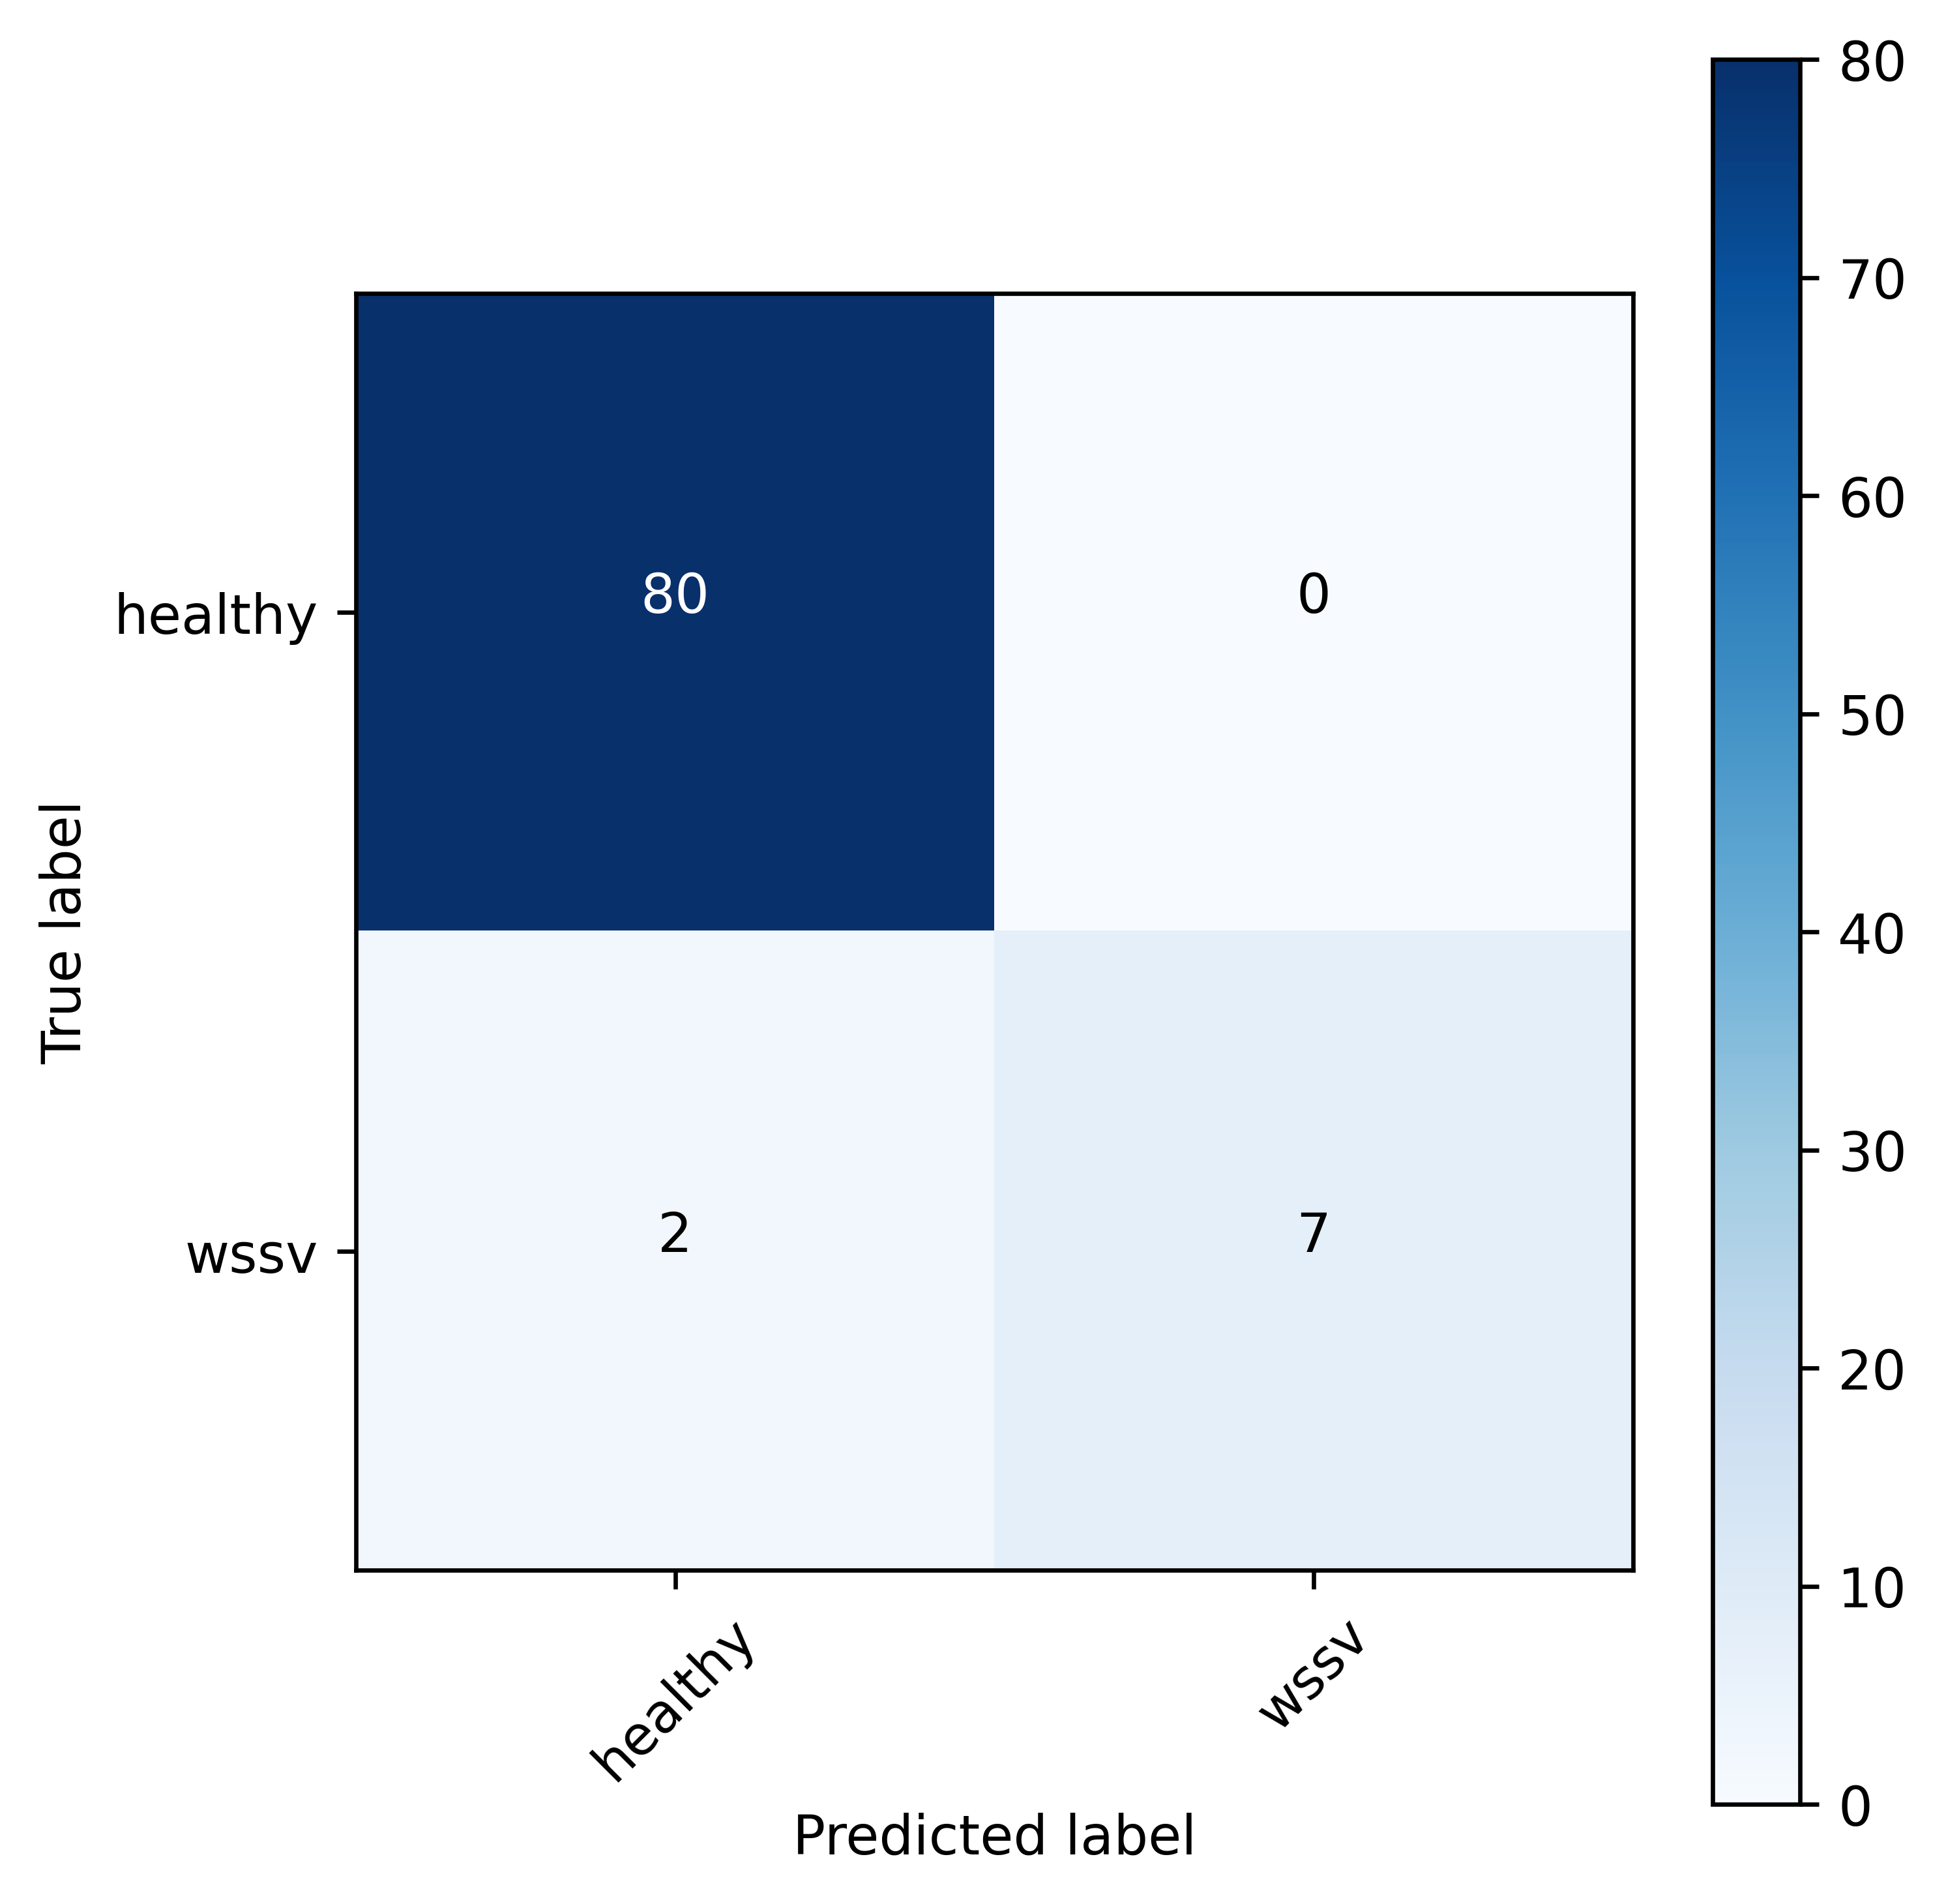

In [20]:
plot_confusion_matrix(
    np.where(np.array(sigmoid_tf_output) > 0.5, 1, 0),
    test_labels.flatten(),
)